In [203]:
!easy_install fancyimpute

Searching for fancyimpute
Best match: fancyimpute 0.4.2
Adding fancyimpute 0.4.2 to easy-install.pth file

Using /anaconda3/lib/python3.6/site-packages
Processing dependencies for fancyimpute
Finished processing dependencies for fancyimpute


In [204]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from fancyimpute import SimpleFill, KNN, SoftImpute, IterativeSVD, IterativeImputer, MatrixFactorization, NuclearNormMinimization, BiScaler

%matplotlib inline

# Basic data preprocessing, same as Code for Module IV

In [431]:
%pwd

'/Users/pengfeihe/Downloads/DataScience'

In [436]:
path = '/Users/pengfeihe/Downloads/DataScience/'

In [437]:
df = pd.read_csv(f'{path}/data7.csv')
print(df.shape)
df.head(2)

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,unnamed
0,8670,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.1466,0.08087,...,26.00,124.9,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019,NaN
1,8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.0226,0.01171,...,15.54,87.4,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915,NaN


In [438]:
'''Keep aside test data first'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df, 398)

print(df_trn_val.shape,df_tst.shape)

(398, 33) (171, 33)


In [439]:
# Firstly, lets drop the two useless column :unnamed, id
df_trn_val1 = df_trn_val.drop(["unnamed","id"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(398, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.1466,0.08087,0.1931,...,19.26,26.00,124.9,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.0226,0.01171,0.1337,...,13.62,15.54,87.4,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,B,NaN,19.10,97.03,687.3,0.08992,0.09823,0.0594,0.04819,NaN,...,16.25,26.19,109.1,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472


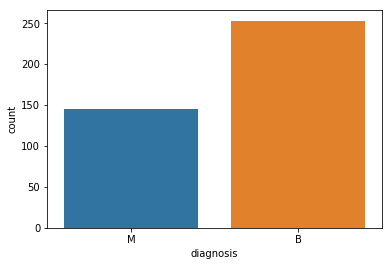

In [440]:
# Firstly, let us have a basic understanding of the frequency of dia
sns.countplot(df_trn_val1['diagnosis'],label="Count")

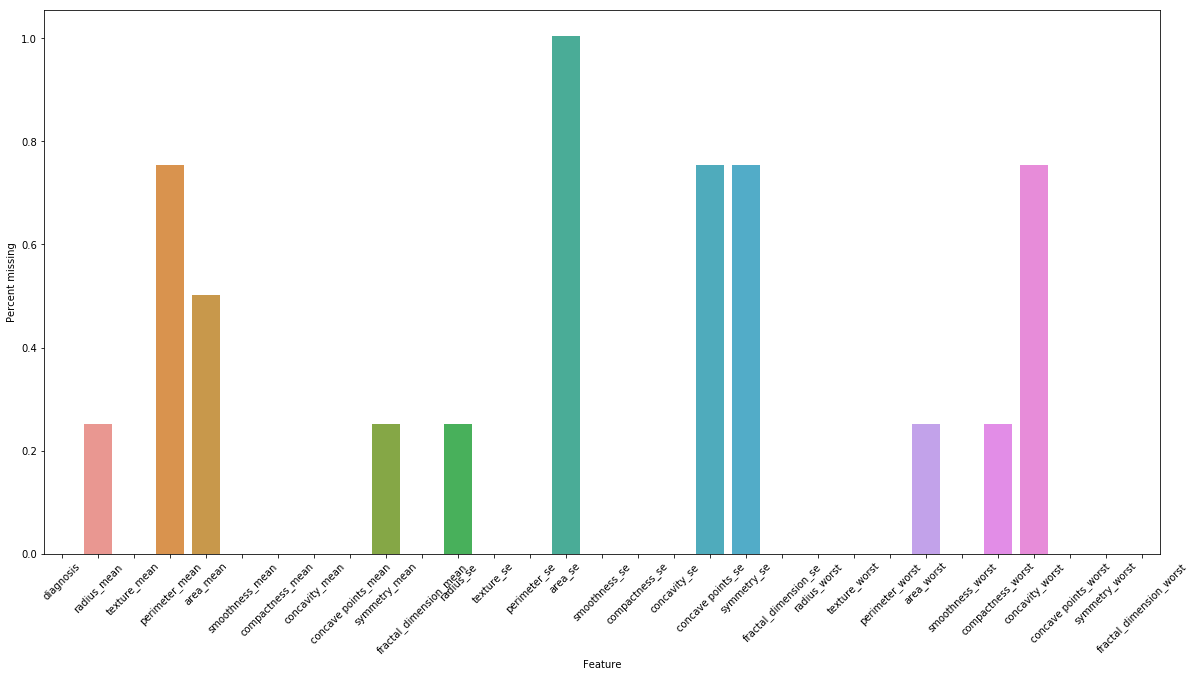

In [441]:
# Let's check whether there is a missing value

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [442]:
#Define a function to convert object types and string types to category type
def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

#Define a function to convert catalogical feature to numerical value
def mydf_to_nums(df):
    df_copy = df.copy()
    for label, value in df.items():
        if not is_numeric_dtype(value):
            df_copy[label] = value.cat.codes
    return df_copy

In [443]:
df_trn_val1.head(20)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.15460,0.23940,0.37910,0.15140,0.2837,0.08019
1,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.11470,0.11860,0.05366,0.2309,0.06915
2,B,NaN,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,NaN,...,16.25,26.19,109.10,809.8,0.13130,0.30300,0.18040,0.14890,0.2962,0.08472
3,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,...,13.86,23.02,89.69,580.9,0.11720,0.19580,0.18100,0.08388,0.3297,0.07834
4,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,...,15.67,27.95,102.80,759.4,0.17860,0.41660,0.50060,0.20880,0.3900,0.11790
5,M,20.26,23.03,132.40,NaN,0.09078,0.13130,0.14650,0.08683,0.2095,...,24.22,31.59,156.10,1750.0,0.11900,0.35390,0.40980,0.15730,0.3689,0.08368
6,B,12.18,17.84,77.79,451.1,0.10450,0.07057,0.02490,0.02941,0.1900,...,12.83,20.92,82.14,495.2,0.11400,0.09358,0.04980,0.05882,0.2227,0.07376
7,M,22.27,19.67,152.80,1509.0,0.13260,0.27680,0.42640,0.18230,0.2556,...,28.40,28.01,206.80,2360.0,0.17010,0.69970,0.96080,0.29100,0.4055,0.09789
8,B,12.63,20.76,82.15,480.4,0.09933,0.12090,0.10650,0.06021,0.1735,...,13.33,25.47,89.00,527.4,0.12870,0.22500,0.22160,0.11050,0.2226,0.08486
9,B,14.26,19.65,97.83,629.9,0.07837,0.22330,0.30030,0.07798,0.1704,...,15.30,23.73,107.00,709.0,0.08949,0.41930,NaN,0.15050,0.2398,0.10820


In [444]:
df_trn_val1 = str_to_cat(df_trn_val1)

In [445]:
df_trn_val1 = mydf_to_nums(df_trn_val1)

In [446]:
# now we can see M and B of diagnosis has been mapped to 1 and 0
df_trn_val1.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.15460,0.23940,0.3791,0.15140,0.2837,0.08019
1,0,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.11470,0.1186,0.05366,0.2309,0.06915
2,0,NaN,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,NaN,...,16.25,26.19,109.10,809.8,0.13130,0.30300,0.1804,0.14890,0.2962,0.08472
3,0,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,...,13.86,23.02,89.69,580.9,0.11720,0.19580,0.1810,0.08388,0.3297,0.07834
4,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,...,15.67,27.95,102.80,759.4,0.17860,0.41660,0.5006,0.20880,0.3900,0.11790
5,1,20.26,23.03,132.40,NaN,0.09078,0.13130,0.14650,0.08683,0.2095,...,24.22,31.59,156.10,1750.0,0.11900,0.35390,0.4098,0.15730,0.3689,0.08368
6,0,12.18,17.84,77.79,451.1,0.10450,0.07057,0.02490,0.02941,0.1900,...,12.83,20.92,82.14,495.2,0.11400,0.09358,0.0498,0.05882,0.2227,0.07376
7,1,22.27,19.67,152.80,1509.0,0.13260,0.27680,0.42640,0.18230,0.2556,...,28.40,28.01,206.80,2360.0,0.17010,0.69970,0.9608,0.29100,0.4055,0.09789
8,0,12.63,20.76,82.15,480.4,0.09933,0.12090,0.10650,0.06021,0.1735,...,13.33,25.47,89.00,527.4,0.12870,0.22500,0.2216,0.11050,0.2226,0.08486
9,0,14.26,19.65,97.83,629.9,0.07837,0.22330,0.30030,0.07798,0.1704,...,15.30,23.73,107.00,709.0,0.08949,0.41930,NaN,0.15050,0.2398,0.10820


In [447]:
# We will use KNN to imputate the invalid data
df_trn_val1 = pd.DataFrame(KNN(k=3).fit_transform(df_trn_val1),
                                  index=df_trn_val1.index, columns=df_trn_val1.columns)

Imputing row 1/398 with 0 missing, elapsed time: 0.042
Imputing row 101/398 with 0 missing, elapsed time: 0.042
Imputing row 201/398 with 1 missing, elapsed time: 0.043
Imputing row 301/398 with 0 missing, elapsed time: 0.043


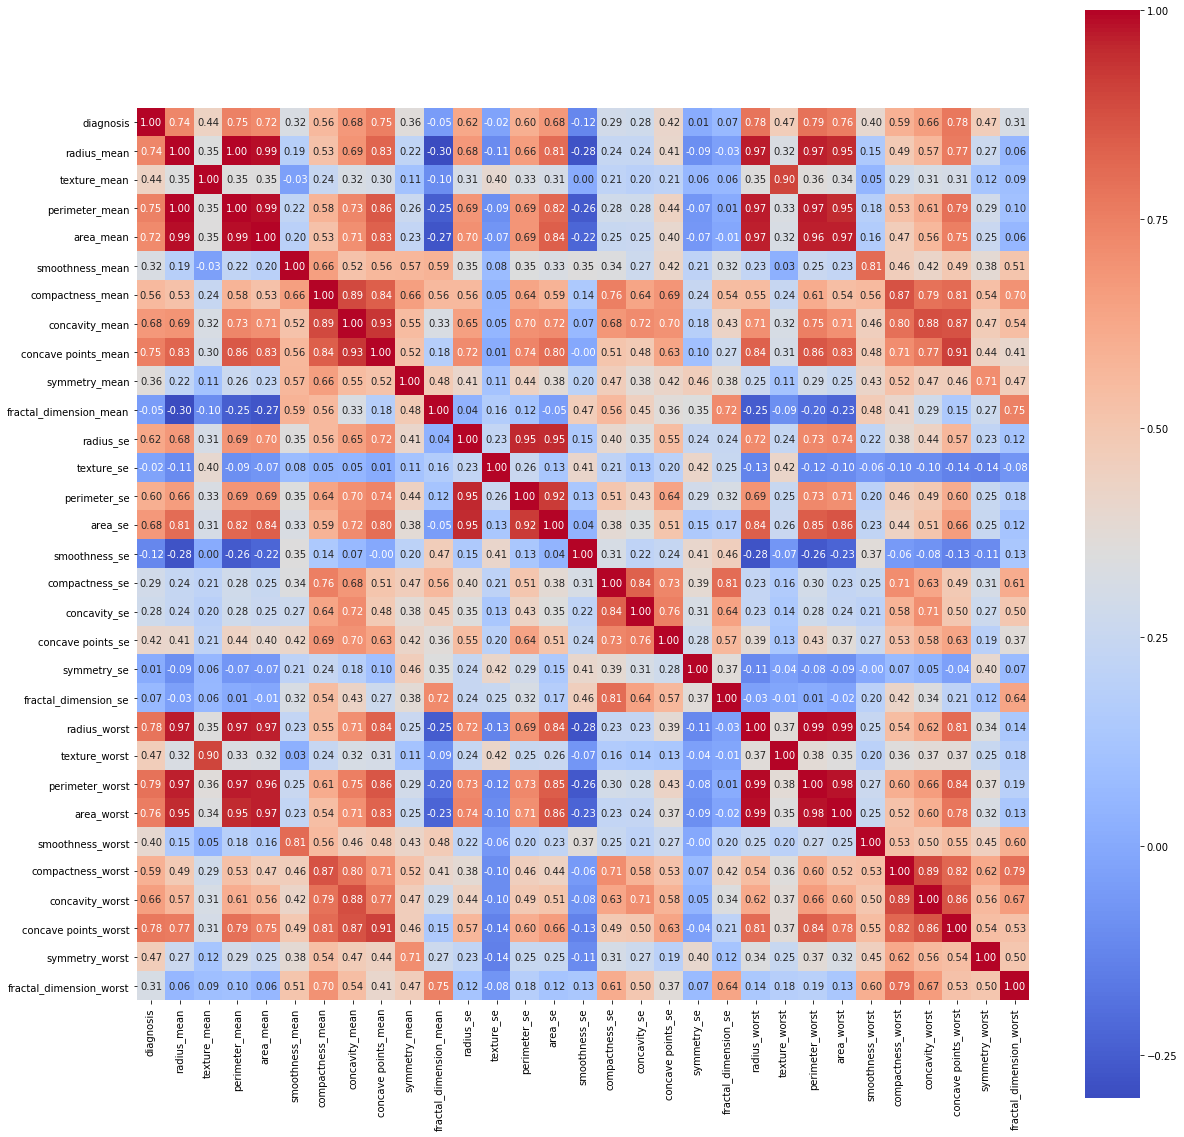

In [448]:
# .corr is used for find corelation
corr = df_trn_val1.corr() 
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= True, yticklabels= True,
           cmap= 'coolwarm')

# KEY STRATEGY

# For each cell, there are ten real-valued features are computed. As the description of the data says "The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius."
# So there is basically two approach to deal with this data:
# 1 to treat the 32 columns of data as a whole
# 2 to treat the the data as three separate parts (mean, se, worst) and then choose the best one

# To demonstrate our understanding, we will firstly use the first approach.  And then pick the "mean" part as the representation of second approach. And then choose the best one from them.

# Approach 1: Treat 32 columns together

In [449]:
# From the graph of cell 66, and according to the discussion with professor. We know that radius_mean, \
# perimeter_mean and area_mean are highly related. So we only choose perimeter_mean. Similarly, we will choose \
# perimeter_se, perimeter_worst, texture_mean, texture_se, texture_worst etc

In [450]:
drop_list = ['area_mean','radius_mean','compactness_mean','concave points_mean','concave points_mean',
            'area_se','radius_se','compactness_se','concave points_se','concave points_se',
            'area_worst','radius_worst','compactness_worst','concave points_worst','concave points_worst']
df_approach1 = df_trn_val1.drop(drop_list,axis = 1 )        
df_approach1.head()

,diagnosis,texture_mean,perimeter_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,perimeter_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,texture_worst,perimeter_worst,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,1.0,19.48,101.70,0.10920,0.14660,0.193100,0.05796,0.7859,3.0940,0.006240,0.02813,0.01397,0.002461,26.00,124.90,0.15460,0.3791,0.2837,0.08019
1,0.0,13.12,81.89,0.06955,0.02260,0.133700,0.05581,0.4690,1.1150,0.004731,0.01652,0.01619,0.002081,15.54,87.40,0.09616,0.1186,0.2309,0.06915
2,0.0,19.10,97.03,0.08992,0.05940,0.165517,0.05852,0.9480,2.1710,0.005332,0.01536,0.01522,0.002815,26.19,109.10,0.13130,0.1804,0.2962,0.08472
3,0.0,16.17,83.18,0.09879,0.03296,0.173500,0.06200,0.9050,0.9975,0.002887,0.01613,0.01870,0.001972,23.02,89.69,0.11720,0.1810,0.3297,0.07834
4,1.0,18.66,85.98,0.11580,0.12260,0.212800,0.06777,0.8937,1.8970,0.006532,0.02905,0.01743,0.003643,27.95,102.80,0.17860,0.5006,0.3900,0.11790


In [451]:
# we will use four models: RandomForestClassifier, gradientBoosting, logisticRegression, kNeighborsClassifier
gradientBoosting = GradientBoostingClassifier()
logisticRegression = LogisticRegression()
kNeighborsClassifier = KNeighborsClassifier()

In [452]:
# split data
X_full = df_approach1.drop('diagnosis', axis=1)
y = df_approach1['diagnosis']
x_trn, x_val, y_trn, y_val = train_test_split(X_full, y, random_state=1)

In [453]:
# test gradientBoosting
gradientBoosting.fit(x_trn, y_trn)
y_prd = gradientBoosting.predict(x_val)
score2 = accuracy_score(y_val,y_prd)
print("gradientBoosting {}".format(score2))
print()

gradientBoosting 0.92



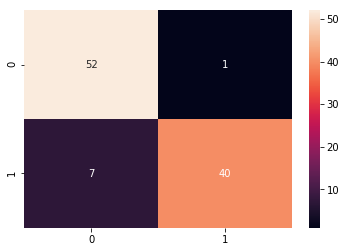

In [454]:
cm_2 = confusion_matrix(y_val,y_prd)
sns.heatmap(cm_2,annot=True,fmt="d")

In [455]:
# test logisticRegression
logisticRegression.fit(x_trn, y_trn)
y_prd = logisticRegression.predict(x_val)
score2 = accuracy_score(y_val,y_prd)
print("logisticRegression {}".format(score2))
print()

logisticRegression 0.88



In [456]:
# test kNeighborsClassifier
kNeighborsClassifier.fit(x_trn, y_trn)
y_prd = kNeighborsClassifier.predict(x_val)
score2 = accuracy_score(y_val,y_prd)
print("kNeighborsClassifier {}".format(score2))
print()

kNeighborsClassifier 0.9



In [457]:
# test RandomForestClassifier with different n_estimators
test = [1, 10, 50, 100]
for index in range(0, 4):
    bagging_model=RandomForestClassifier(n_jobs = -1, n_estimators = test[index],
                                 bootstrap = True)
    
    bagging_model.fit(x_trn, y_trn)
    y_prd = bagging_model.predict(x_val)
    score = accuracy_score(y_val,y_prd)
    
    print("n_estimators {} score is {}".format(test[index], score))
    print()

n_estimators 1 score is 0.84

n_estimators 10 score is 0.94

n_estimators 50 score is 0.91

n_estimators 100 score is 0.92



In [458]:
# Thus, we can see that we can choose n-estimators of 50 to get a score of 0.98

# Approach 2: Treat 10 columns separately (we choose "mean" column as representation)

In [459]:
features_mean= list(df_trn_val1.columns[0:11])

In [460]:
df_mean = df_trn_val1[features_mean]
df_mean.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1.0,15.460000,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.193100,0.05796
1,0.0,12.890000,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.133700,0.05581
2,0.0,14.732902,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.165517,0.05852
3,0.0,12.940000,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.173500,0.06200
4,1.0,13.170000,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.212800,0.06777


In [461]:
# Similarly, we only choose those features are not co-related
df_approach2 = df_mean.drop(['radius_mean', 'area_mean', 'concave points_mean', 'compactness_mean'], axis=1)

In [462]:
df_approach2.head()

,diagnosis,texture_mean,perimeter_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean
0,1.0,19.48,101.70,0.10920,0.14660,0.193100,0.05796
1,0.0,13.12,81.89,0.06955,0.02260,0.133700,0.05581
2,0.0,19.10,97.03,0.08992,0.05940,0.165517,0.05852
3,0.0,16.17,83.18,0.09879,0.03296,0.173500,0.06200
4,1.0,18.66,85.98,0.11580,0.12260,0.212800,0.06777


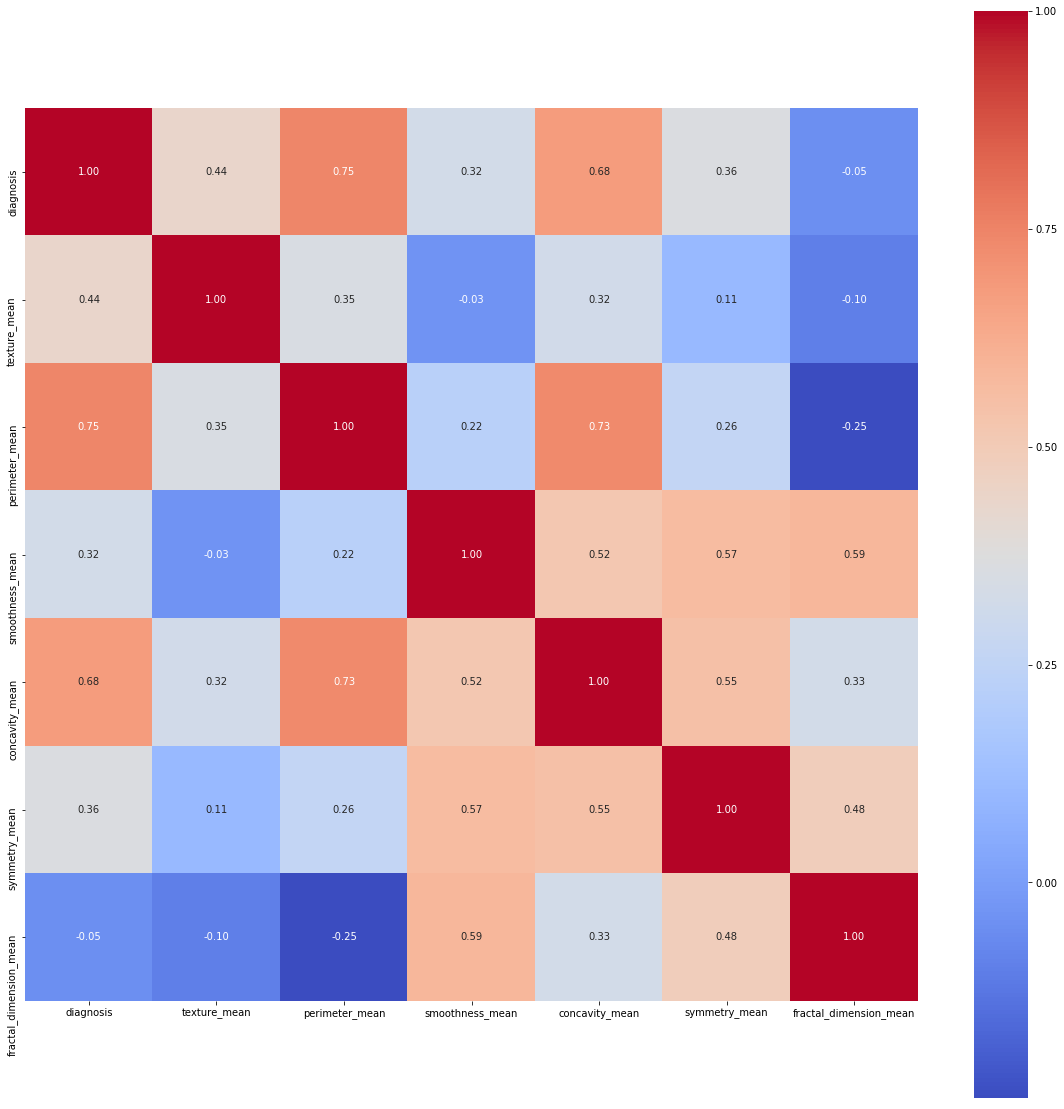

In [463]:
# corr = df_mean.corr() # .corr is used for find corelation
plt.figure(figsize=(20,20))
sns.heatmap(df_approach2.corr(), cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= True, yticklabels= True,
           cmap= 'coolwarm')

In [464]:
# Simaliarly, we will use four models: RandomForestClassifier, gradientBoosting, logisticRegression, kNeighborsClassifier
gradientBoosting = GradientBoostingClassifier()
logisticRegression = LogisticRegression()
kNeighborsClassifier = KNeighborsClassifier()

In [465]:
# split data
X_full = df_approach2.drop('diagnosis', axis=1)
y = df_approach2['diagnosis']
x_trn, x_val, y_trn, y_val = train_test_split(X_full, y, random_state=1)

In [466]:
# test gradientBoosting
gradientBoosting.fit(x_trn, y_trn)
y_prd = gradientBoosting.predict(x_val)
score2 = accuracy_score(y_val,y_prd)
print("gradientBoosting {}".format(score2))
print()

gradientBoosting 0.9



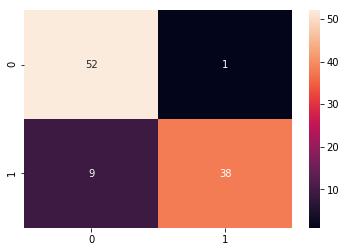

In [467]:
cm_2 = confusion_matrix(y_val,y_prd)
sns.heatmap(cm_2,annot=True,fmt="d")

In [468]:
# test logisticRegression
logisticRegression.fit(x_trn, y_trn)
y_prd = logisticRegression.predict(x_val)
score2 = accuracy_score(y_val,y_prd)
print("logisticRegression {}".format(score2))
print()

logisticRegression 0.83



In [469]:
# test kNeighborsClassifier
kNeighborsClassifier.fit(x_trn, y_trn)
y_prd = kNeighborsClassifier.predict(x_val)
score2 = accuracy_score(y_val,y_prd)
print("kNeighborsClassifier {}".format(score2))
print()

kNeighborsClassifier 0.91



In [470]:
# test RandomForestClassifier with different n_estimators
test = [1, 10, 50, 100]
for index in range(0, 4):
    bagging_model=RandomForestClassifier(n_jobs = -1, n_estimators = test[index],
                                 bootstrap = True)
    
    bagging_model.fit(x_trn, y_trn)
    y_prd = bagging_model.predict(x_val)
    score = accuracy_score(y_val,y_prd)
    
    print("n_estimators {} score is {}".format(test[index], score))
    print()

n_estimators 1 score is 0.87

n_estimators 10 score is 0.89

n_estimators 50 score is 0.91

n_estimators 100 score is 0.91



In [134]:
# Thus, we can see that we can choose n-estimators of 10 to get a score of 0.97